In [2]:
from functions.functions import *
import warnings
!pip install soundfile
!pip install torchaudio
import soundfile
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True" # This is to avoid the memory fragmentation

# Retina display
%config InlineBackend.figure_format = 'retina'

CUDA not available. Using CPU.
  Obtaining dependency information for soundfile from https://files.pythonhosted.org/packages/50/ff/26a4ee48d0b66625a4e4028a055b9f25bc9d7c7b2d17d21a45137621a50d/soundfile-0.12.1-py2.py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.0 MB 262.6 kB/s eta 0:00:04
   - -------------------------------------- 0.0/1.0 MB 262.6 kB/s eta 0:00:04
   - -------------------------------------- 0.0/1.0 MB 262.6 kB/s eta 0:00:04
   - -------------------------------------- 0.0/1.0 MB 140.3 kB/s eta 0:00:07
   -- ------------------------------------- 0.1/1.0 MB 172.4 kB/s eta 0:00:06
   -- ------------------------------------- 0.1/1.0 MB 187.3 kB/s eta 0:00:06
   --- ----

  Obtaining dependency information for torchaudio from https://files.pythonhosted.org/packages/9b/f5/d3c9b0ba802e2b8e363c5366b37b6b5fb703ac052a5afc334c36b255401f/torchaudio-2.4.1-cp312-cp312-win_amd64.whl.metadata
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.4 MB 162.5 kB/s eta 0:00:15
    --------------------------------------- 0.0/2.4 MB 145.2 kB/s eta 0:00:17
    --------------------------------------- 0.0/2.4 MB 163.4 kB/s eta 0:00:15
    --------------------------------------- 0.0/2.4 MB 163.4 kB/s eta 0:00:15
    --------------------------------------- 0.0/2.4 MB 163.4 kB/s eta 0:00:15
   - -------------------------------------- 0.1/2.4 MB 156.1 kB/s eta 0:00:16
   - -------------------------------------- 0.1/2.4 MB 156.1 kB/s eta 0:00:16
   - ----------------------------

In [2]:
device

device(type='cuda')

In [3]:
# Loading and preprocessing the image
#img_path = "dog.jpg"  # Make sure this path is correct
#original_img = load_and_preprocess_image(img_path)
img_path = "Lenna.png"
if not (os.path.exists(img_path)):
  !wget "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png" -O "Lenna.png"
original_img = load_and_preprocess_image(img_path, top = 0 , left = 0 , crop_size=512)


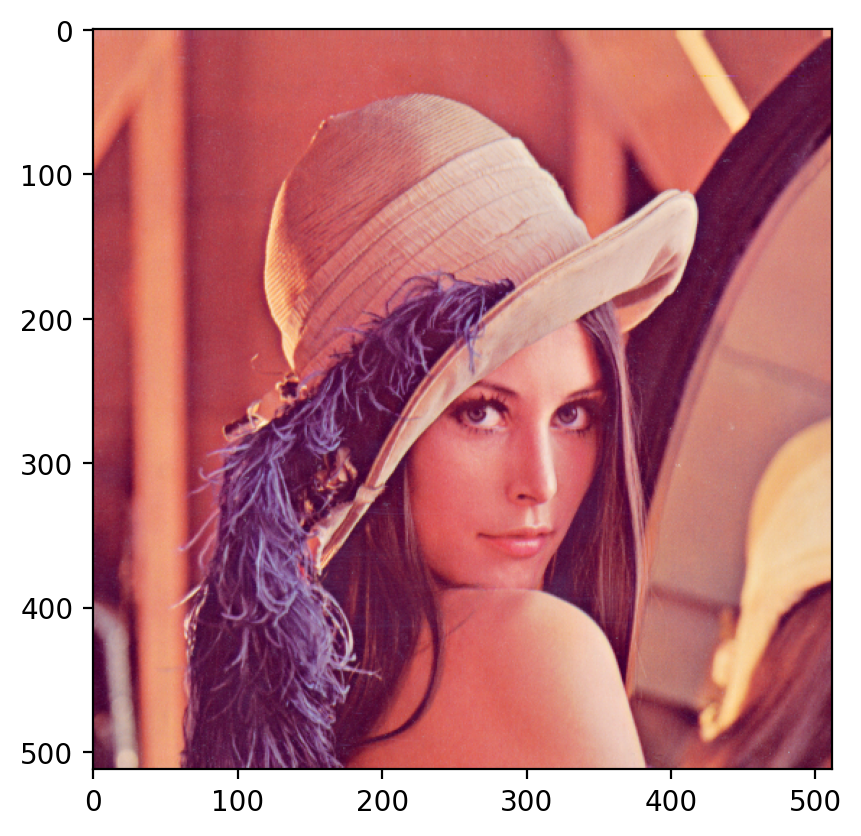

In [4]:
plt.imshow(rearrange(original_img, 'c h w -> h w c').numpy())

In [5]:
X, Y = (create_coordinate_map(original_img))
scaled_X, scaler = scale_coordinates(X)

In [6]:
scaled_X.shape, Y.shape

(torch.Size([262144, 2]), torch.Size([262144, 3]))

In [7]:
X_rff = create_rff_features(scaled_X, 20000, 0.008).to(device)

In [9]:
net = LinearModel(X_rff.shape[1], 3).to(device)
train(net, 0.005, X_rff.to(device), Y.to(device), 1000)

Epoch 0 loss: 0.302498


Epoch 100 loss: 0.037853
Epoch 200 loss: 0.008905
Epoch 300 loss: 0.004639
Epoch 400 loss: 0.003120
Epoch 500 loss: 0.002324
Epoch 600 loss: 0.001877
Epoch 700 loss: 0.001621
Epoch 800 loss: 0.001474
Epoch 900 loss: 0.001389


0.001339870854280889

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


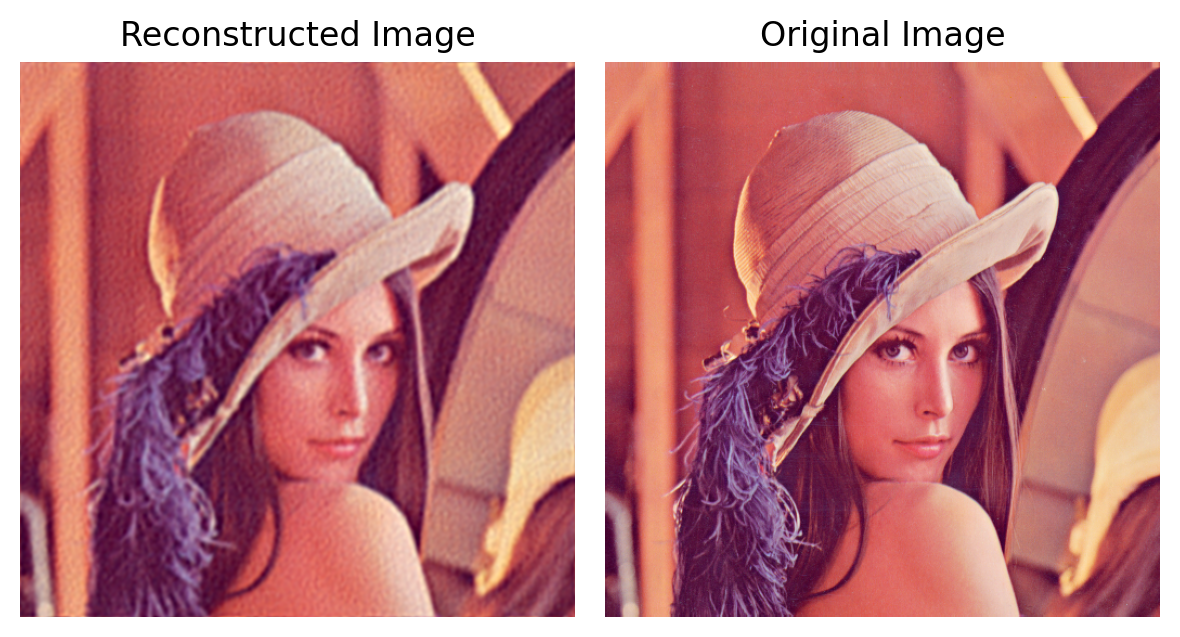

In [10]:
_ = plot_reconstructed_and_original_image(original_img, net, X_rff, title="")

In [11]:
metrics = calculate_metrics(Y.to(device), predict_image(net, X_rff))
print(f"RMSE: {metrics[0]:.6f}, PSNR: {metrics[1]:.6f}")

RMSE: 0.036599, PSNR: 28.730591


In [3]:
from IPython.display import Audio
import torchaudio
org_sound_path = 'trimmed-pokemon-22k.wav'
Audio(org_sound_path)

In [7]:
audio, sr = torchaudio.load('./trimmed-pokemon-22k.wav')
print(f"Sampling frequency: {sr} Hz")
print(audio.shape)
audio = audio[0]

Sampling frequency: 22050 Hz
torch.Size([2, 394584])


In [8]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

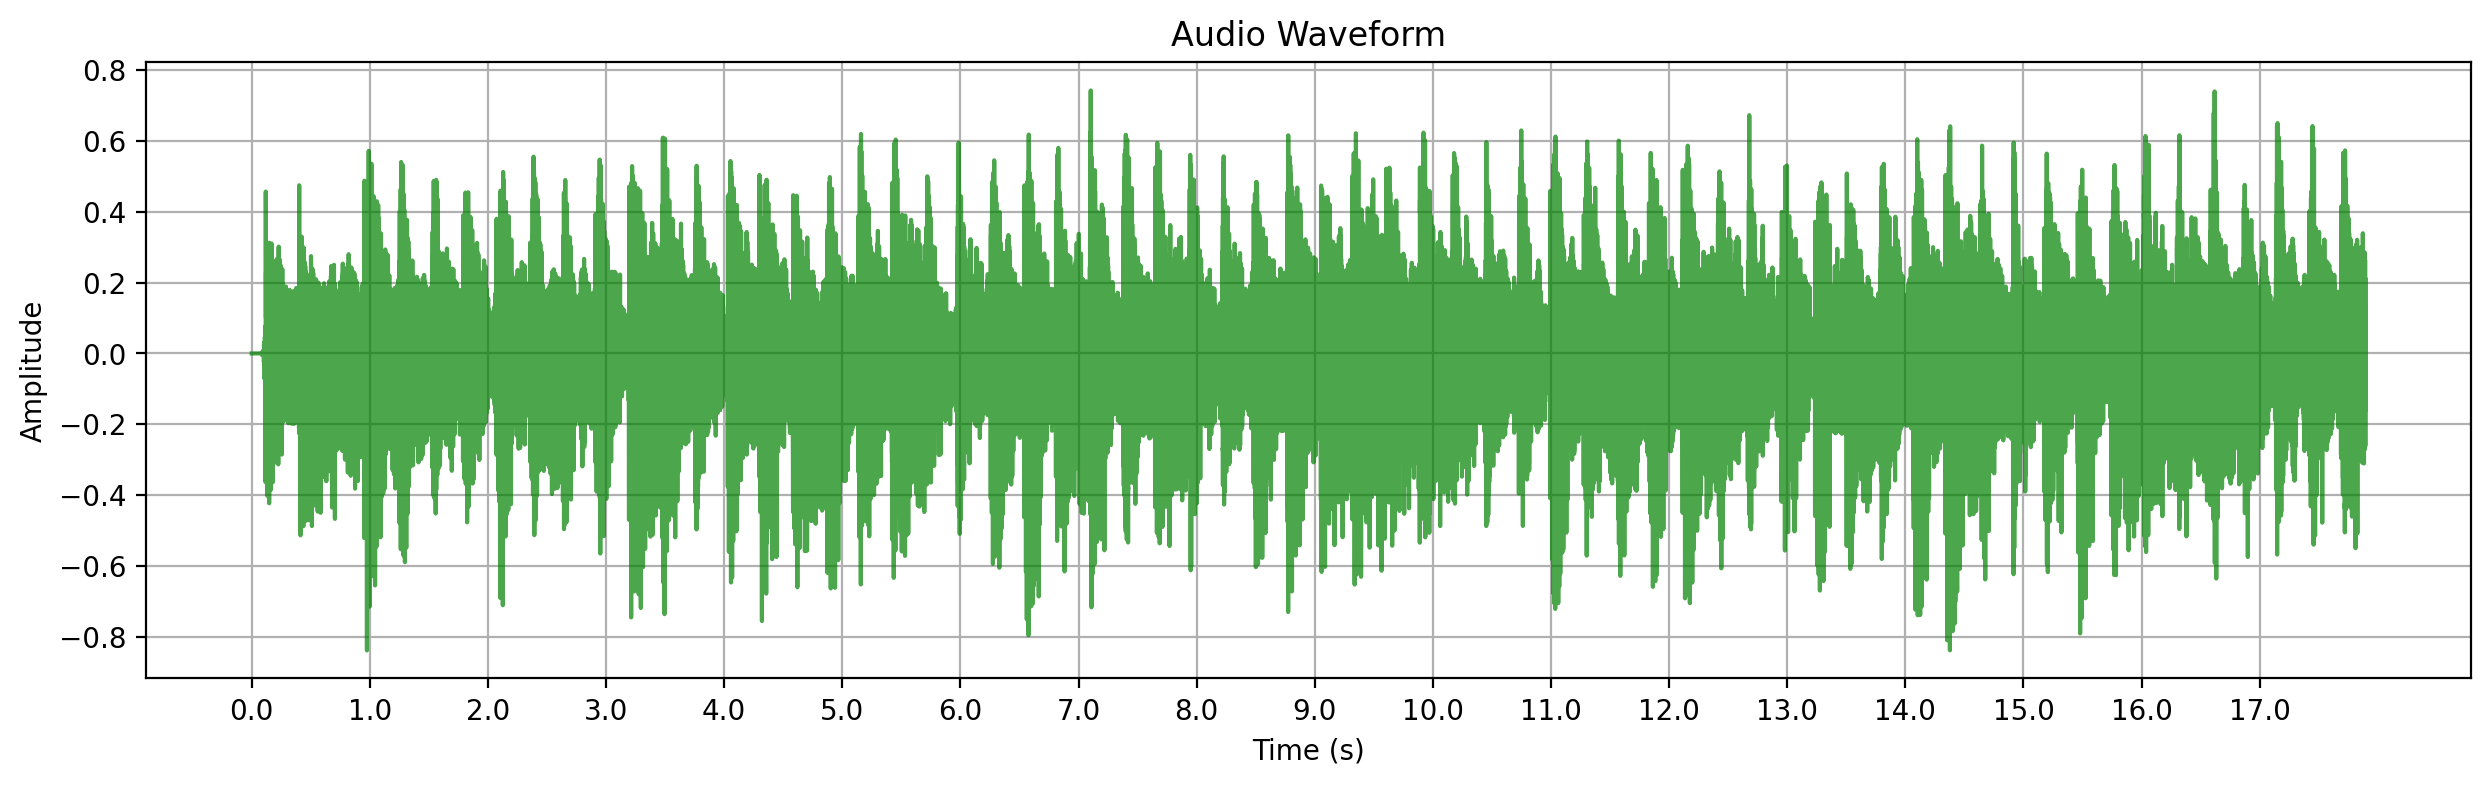

In [9]:
audio_plot(audio, sr, 'green', 'Audio Waveform')

In [17]:
audio_tr = audio[:5*sr]
X = torch.arange(0, len(audio_tr)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([110250, 1])
tensor([[-100.0000],
        [ -99.9982],
        [ -99.9964],
        ...,
        [  99.9964],
        [  99.9982],
        [ 100.0000]])


In [18]:
Audio(audio_tr, rate = sr)

In [39]:
num_features = 3000
sigma = 0.008
X_rff = create_rff_features(X, num_features, sigma).to(device)
X_rff.shape

torch.Size([110250, 3000])

In [40]:
net = LinearModel(X_rff.shape[1], 1)
net.to(device)
X_rff.to(device)
audio_tr.to(device)
train(net, 0.001, X_rff, audio_tr.view(-1, 1), 500)

Epoch 0 loss: 0.021316
Epoch 100 loss: 0.017930
Epoch 200 loss: 0.016998
Epoch 300 loss: 0.016579
Epoch 400 loss: 0.016351


0.016215737909078598

In [41]:
net.eval()
with torch.no_grad():
  pred_audio = net(X_rff).cpu().numpy().flatten()

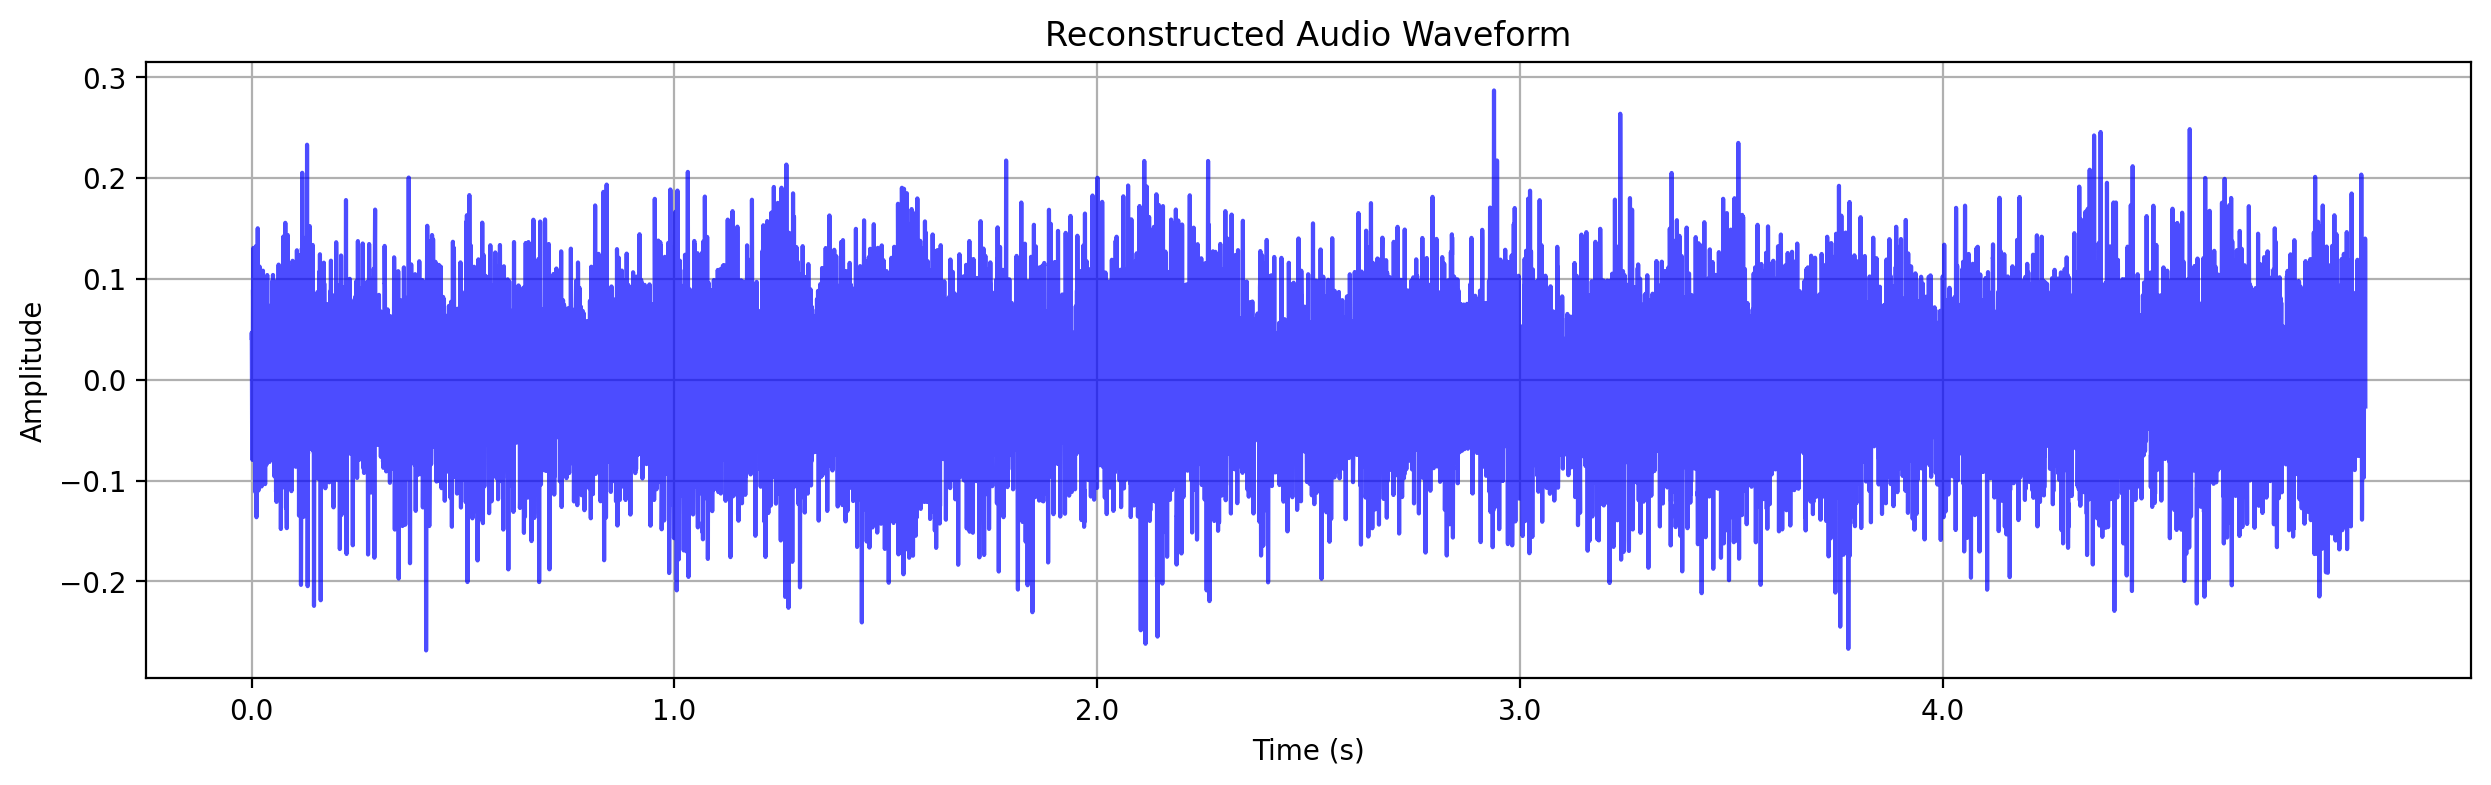

In [45]:
display(Audio(pred_audio, rate = sr))
audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform')

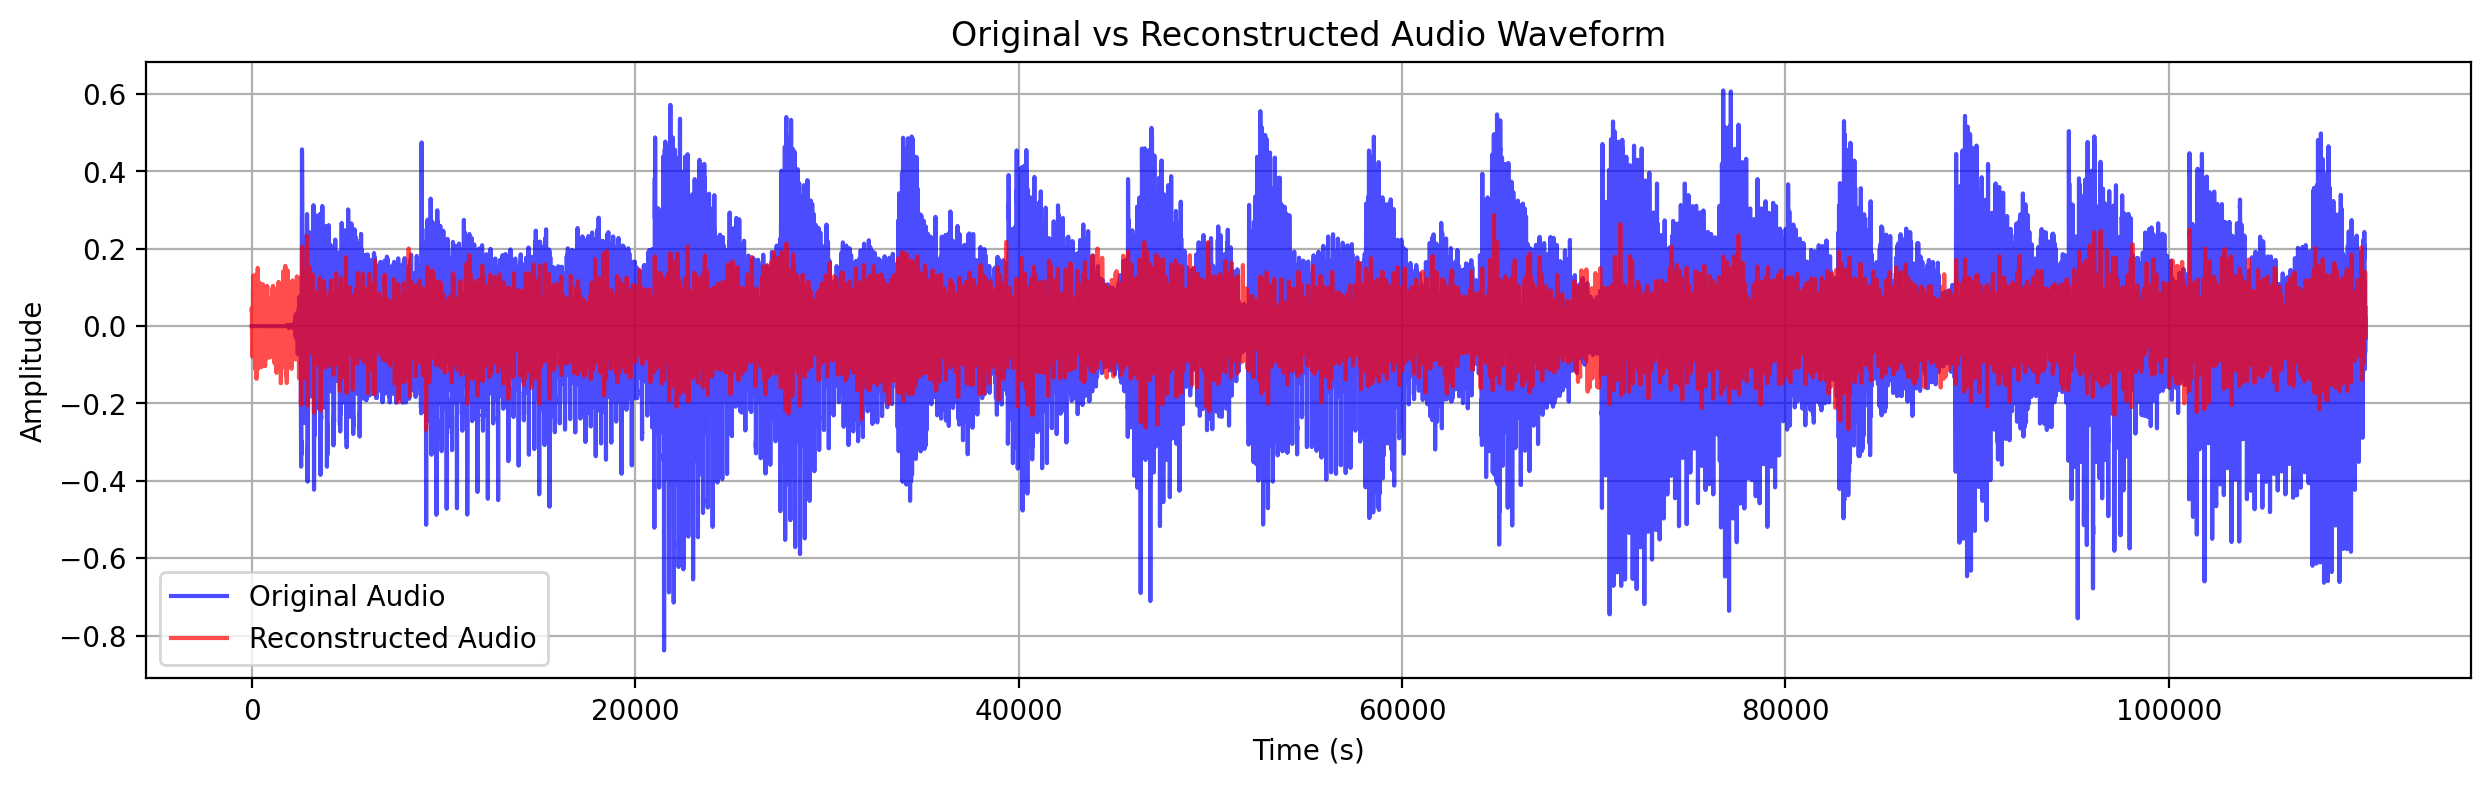

In [46]:
plt.figure(figsize=(15, 4))
plt.plot(audio_tr, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()